<h1> <center> Google Analytics Customer Revenue Prediction  </center> <h1>

## Project Abstract ##

<b>Situation</b> – This project is an open Kaggle competition with a final submission deadline of November 30, 2018. The scenario is that the 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies and the objective of this exploration is to identify an optimized model that can predict revenue per customer which can then be utilized by the marketing team to rethink their strategy and make an informed decision.

<b>Task</b> – In this competition, we’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

<b>Action</b> – There are two datasets (train.csv and test.csv) that contain user transactions from August 1st, 2016 to August 1st, 2017 and August 2nd, 2017 to April 30th, 2018 respectively. Initially, we will conduct exploratory data analysis on the datasets – investigate the statistics of data, identify missing values on each data column, explore target variable distribution, correlation between predictor variables, identify columns that may not be necessary, and then preprocess data to convert categorical predictor variables to numerical variables, remove columns that may be not be needed, impute missing values as needed. The preprocessed data will be scaled, trained using a linear regression baseline model and evaluated through K-Fold cross validation with basic parameter setting using all the features. We will conduct further experimentation by using different parameter settings including regularization, drop features of low importance and determine the optimized model with best RMSE score.

<b>Result</b> – The best model will be used to predict revenue per customer in the test dataset. Submissions are scored on the root mean squared error(RMSE). For each fullVisitorId in the test set, we will predict the natural log of their total revenue in PredictedLogRevenue. We are predicting the natural log of the sum of all transactions per user. For every user in the test set, the target is:


## Model Pipeline ##

<img src="https://drive.google.com/open?id=11lC4gWPriiC1v80itqKiUXLWHprekSQz">

## Problem Setting ##

Our objective was to predict the natural log of total revenue per customer which is a real valued continuous output and we initially believed that linear regression would be an ideal algorithm in such a setting to predict the response variable that is continuous using a set of predictor variables given the basic assumption that there is a linear relationship between the predictor and response variables.

The training dataset contained 872214 records and considering the size of the training dataset, we planned to use mini-batch or stochastic gradient descent methods to obtain optimized estimates of the coefficients for our linear function that best describes the input variables. After cleaning and pre-processing the data, we intended to build a basic linear regression model using basic parameter setting and based on outcome of this initial model, we wanted to perform further experimentation to tune the hyper-parameters including regularization and additional feature engineering to derive more features from the provided input data to improve the parameter estimates for our model and reduce the error. Our intent was also to explore other algorithms and techniques to improve the RMSE score..




## Metrics ##

Submissions are scored on the root mean squared error (RMSE). The root mean squared error function forms our objective/cost function which will be minimized to estimate the optimal parameters for our linear function through Gradient Descent. We originally intended to conduct multiple experiments to obtain convergence using different “number of iterations” value and other hyper-parameters (e.g. learning rate).

RMSE is defined as:

<img src="https://drive.google.com/open?id=1FsOKr-h70q-uDE3DZ1P_0mCxDCN9USrr">

where y-hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one as seen below.

<img src="https://drive.google.com/open?id=1NTM9_eVSyImW0L1osu44vSTD2yHcWYhR">

## Data Load ##

In [1]:
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")
# data manipulation
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
# plot
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
# model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

/Users/kousik/Downloads/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%%time
def load_df(csv_path='input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df
train = load_df('input/train.csv')
test = load_df('input/test.csv')
sub = pd.read_csv('input/sample_submission.csv')
gc.collect()

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 4min 51s, sys: 8.45 s, total: 5min
Wall time: 4min 55s


### Colab Data Load ###

In [2]:
import urllib.request
print('Beginning file download with urllib2...')
url = 'https://storage.googleapis.com/gstoremlbucket/train_fjson.csv'  
urllib.request.urlretrieve(url, './sample_data/train_json.csv')
url = 'https://storage.googleapis.com/gstoremlbucket/test_fjson.csv'  
urllib.request.urlretrieve(url, './sample_data/test_json.csv')

Beginning file download with urllib2...


('./sample_data/test_json.csv', <http.client.HTTPMessage at 0x7f872080d630>)

In [3]:
%%time

def load_df(csv_path='input/train.csv', nrows=None):
    #JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    JSON_COLUMNS = []
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(flatten(df[column]))
         #json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train = load_df('sample_data/train_json.csv')
test = load_df('sample_data/test_json.csv')
#sub = pd.read_csv('input/sample_submission.csv')
gc.collect()

Loaded train_json.csv. Shape: (903653, 56)
Loaded test_json.csv. Shape: (804684, 54)
CPU times: user 33.5 s, sys: 2.05 s, total: 35.5 s
Wall time: 35.5 s


In [3]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


## Data Exploration ##

In [0]:
if test.fullVisitorId.nunique() == len(sub):
    print('Till now, the number of fullVisitorId is equal to the rows in submission. Everything goes well!')
else:
    print('Check it again')

Till now, the number of fullVisitorId is equal to the rows in submission. Everything goes well!


### Target Variable Distribution ###

In [0]:
y = np.nan_to_num(np.array([float(i) for i in train['totals.transactionRevenue']]))
print('The ratio of customers with transaction revenue is', str((y != 0).mean()))   

The ratio of customers with transaction revenue is 0.0127427231470487


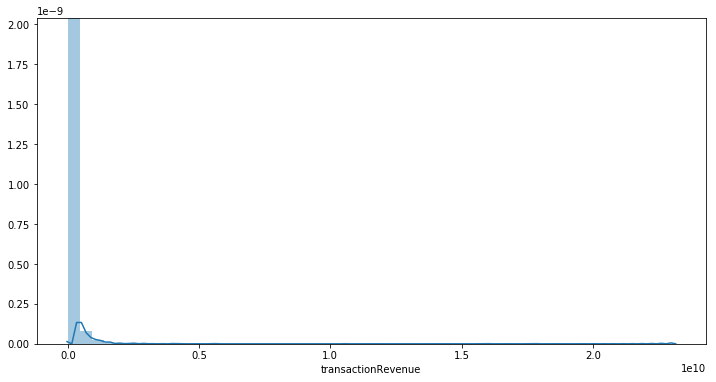

In [0]:
plt.figure(figsize=[12, 6])
sns.distplot(y[y!=0])
plt.xlabel('transactionRevenue')
plt.show()

In [0]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
target = np.log1p(train.groupby("fullVisitorId")["totals.transactionRevenue"].sum())
print('The ratio of customers with transaction revenue is', str((target != 0).mean()))

The ratio of customers with transaction revenue is 0.013996726255903731


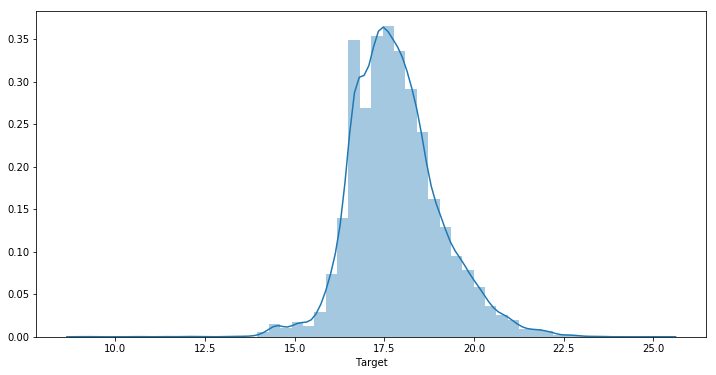

In [0]:
plt.figure(figsize=[12, 6])
sns.distplot(target[target!=0])
plt.xlabel('Target')
plt.show()

### Device Group ###

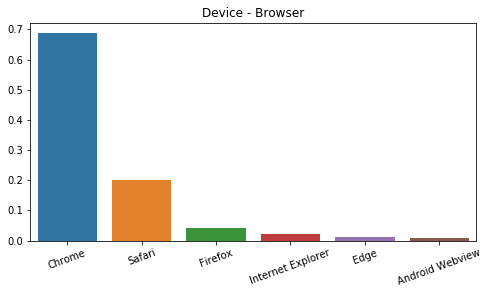

In [0]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title='', max_cat = None):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts() / len(data)
    if max_cat != None:
        plotdata = plotdata[max_cat[0]:max_cat[1]]
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()
plot_categorical(data=train, col='device.browser', size=[8 ,4], xlabel_angle=20, title='Device - Browser', max_cat=[0, 6])

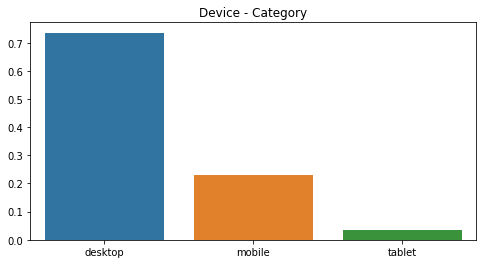

In [0]:
plot_categorical(data=train, col='device.deviceCategory', size=[8 ,4], xlabel_angle=0, title='Device - Category')

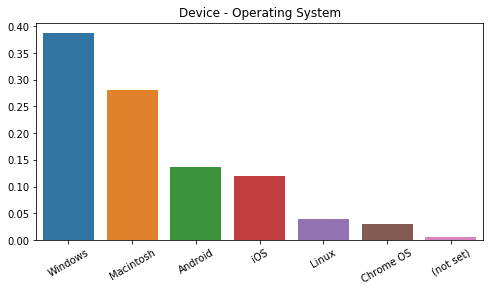

In [0]:
plot_categorical(data=train, col='device.operatingSystem', size=[8 ,4], xlabel_angle=30, 
                 title='Device - Operating System', max_cat = [0, 7])

### Geo Network Group ###

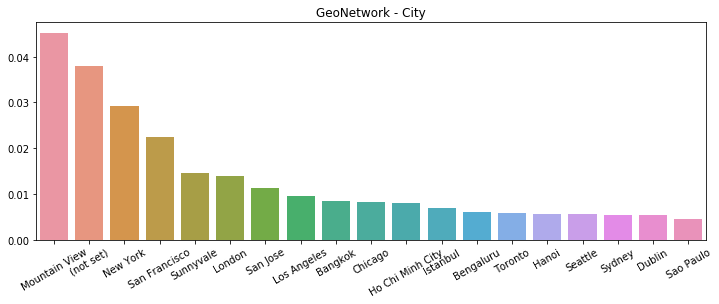

In [0]:
plot_categorical(data=train, col='geoNetwork.city', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - City', max_cat = [1, 20])

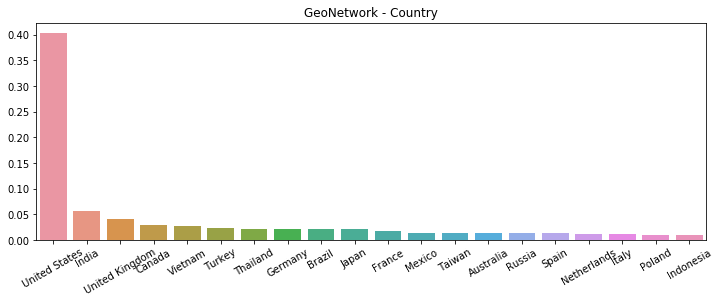

In [0]:
plot_categorical(data=train, col='geoNetwork.country', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Country', max_cat = [0, 20])

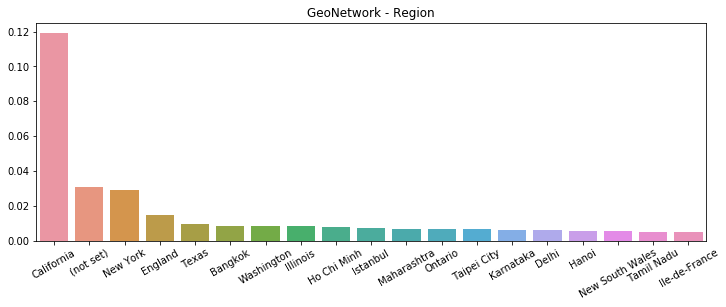

In [0]:
plot_categorical(data=train, col='geoNetwork.region', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Region', max_cat = [1, 20])

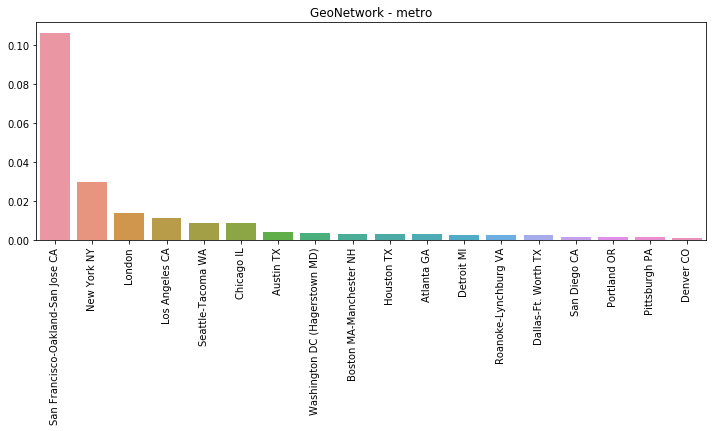

In [0]:
plot_categorical(data=train, col='geoNetwork.metro', size=[12 ,4], xlabel_angle=90, 
                 title='GeoNetwork - metro', max_cat = [2, 20])

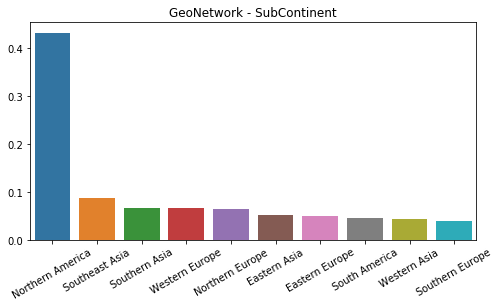

In [0]:
plot_categorical(data=train, col='geoNetwork.subContinent', size=[8 ,4], xlabel_angle=30, 
                 title='GeoNetwork - SubContinent', max_cat = [0, 10])

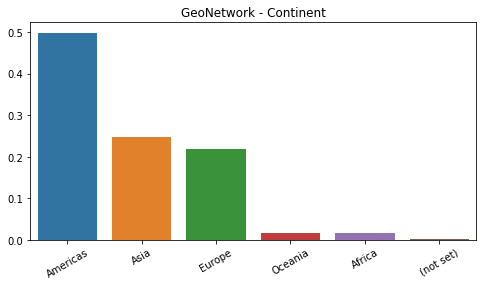

In [0]:
plot_categorical(data=train, col='geoNetwork.continent', size=[8 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Continent')

### Totals Group ###

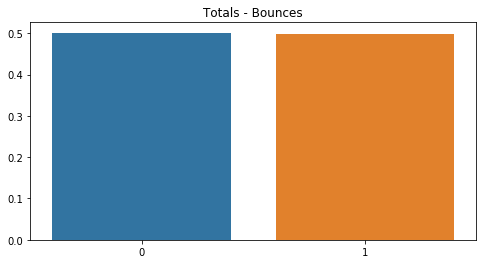

In [0]:
train['totals.bounces'] = train['totals.bounces'].fillna('0')
plot_categorical(data=train, col='totals.bounces', size=[8 ,4], xlabel_angle=0, title='Totals - Bounces')

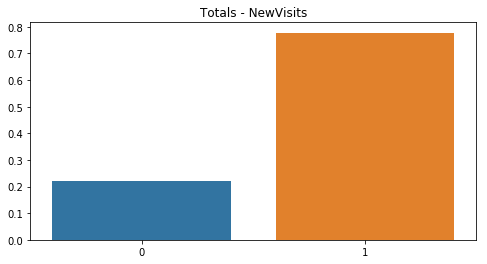

In [0]:
train['totals.newVisits'] = train['totals.newVisits'].fillna('0')
plot_categorical(data=train, col='totals.newVisits', size=[8 ,4], xlabel_angle=0, title='Totals - NewVisits')

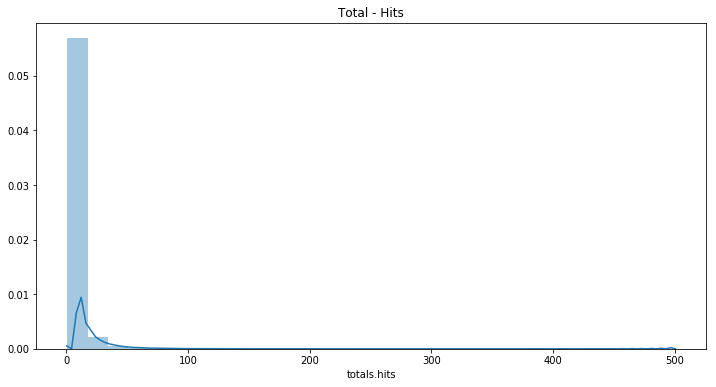

In [0]:
plt.figure(figsize=[12, 6])
sns.distplot(train['totals.hits'].astype('float'), kde=True,bins=30)
plt.xlabel('totals.hits')
plt.title('Total - Hits')
plt.show()

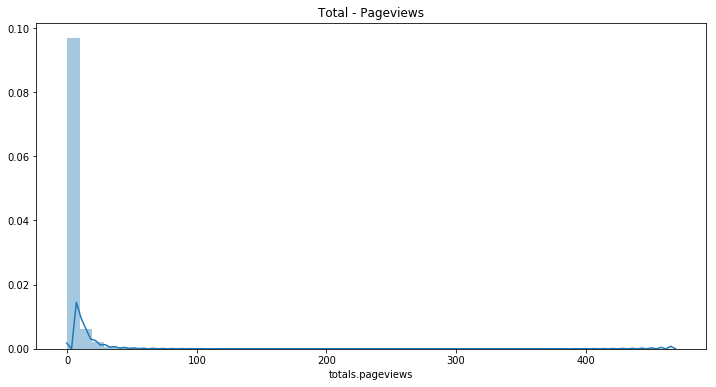

In [0]:
plt.figure(figsize=[12, 6])
sns.distplot(train['totals.pageviews'].astype('float').fillna(0))
plt.xlabel('totals.pageviews')
plt.title('Total - Pageviews')
plt.show()

### Traffic Source Group ###

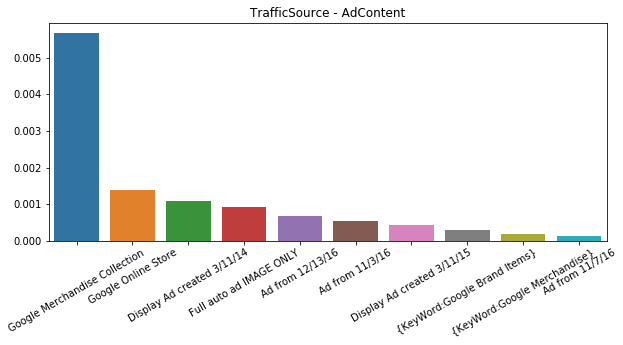

In [0]:
plot_categorical(data=train, col='trafficSource.adContent', size=[10 ,4], xlabel_angle=30, 
                 title='TrafficSource - AdContent', max_cat = [0, 10])

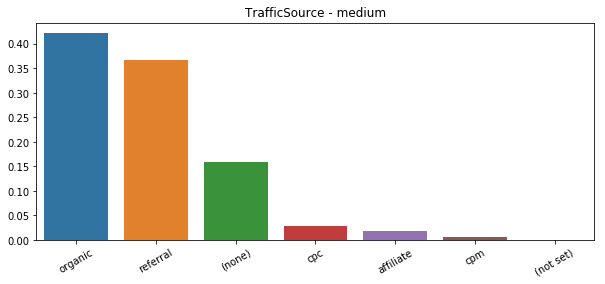

In [0]:
plot_categorical(data=train, col='trafficSource.medium', size=[10 ,4], xlabel_angle=30, 
                 title='TrafficSource - medium')

### Calculating the transaction revenue for each category in each feature ###

In [4]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
plotly.offline.init_notebook_mode(connected=True)
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')

geo_net_cols = ['geoNetwork.continent' ,'geoNetwork.subContinent', 'geoNetwork.country']
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=["Mean Transaction revenue: Continent", "Mean Transaction revenue: SubContinent", "Mean Transaction revenue: Country"], print_grid=False)


colors = ["green","blue","red"]
plts = []
for color, column in enumerate(geo_net_cols):
    temporary_var = train.groupby(column).agg({"totals.transactionRevenue": "mean"}).reset_index().rename(columns={"totals.transactionRevenue" : "Mean Revenue"})
    temporary_var = temporary_var.dropna().sort_values("Mean Revenue", ascending = False)
    each_bar = go.Bar(x = temporary_var["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[color]), y = temporary_var[column][::-1])
    plts.append(each_bar)

fig.append_trace(plts[0], 1, 1)
fig.append_trace(plts[1], 1, 2)
fig.append_trace(plts[2], 2, 1)

fig['layout'].update(height=800, showlegend=False, title="Mean Transaction revenue by GeoNetwork Attributes")
plotly.offline.iplot(fig)

In [5]:
# plotly globe credits - https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
temporary_var = train["geoNetwork.country"].value_counts()

colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = temporary_var.index,
        z = temporary_var.values,
        locationmode = 'country names',
        text = temporary_var.values,
        marker = dict(
            line = dict(color = '#fff', width = 2)) )           ]

layout = dict(
    height=500,
    title = 'Visits by Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

# plotly globe credits - https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals

temporary_var = train.groupby("geoNetwork.country").agg({"totals.transactionRevenue" : "mean"}).reset_index()

colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = temporary_var['geoNetwork.country'],
        z = temporary_var['totals.transactionRevenue'],
        locationmode = 'country names',
        text = temporary_var['totals.transactionRevenue'],
        marker = dict(
            line = dict(color = '#fff', width = 2)) ) ]

layout = dict(
    height=500,
    title = 'Mean Transaction Revenue by Countries',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

### Other Groups ###

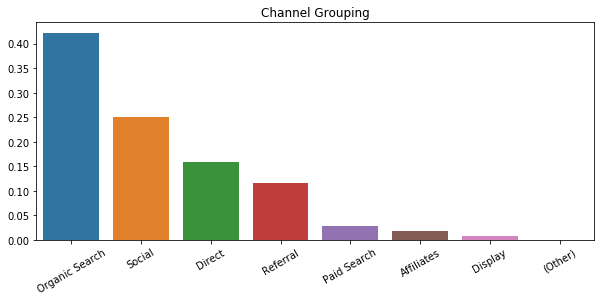

In [0]:
plot_categorical(data=train, col='channelGrouping', size=[10 ,4], xlabel_angle=30, 
                 title='Channel Grouping')

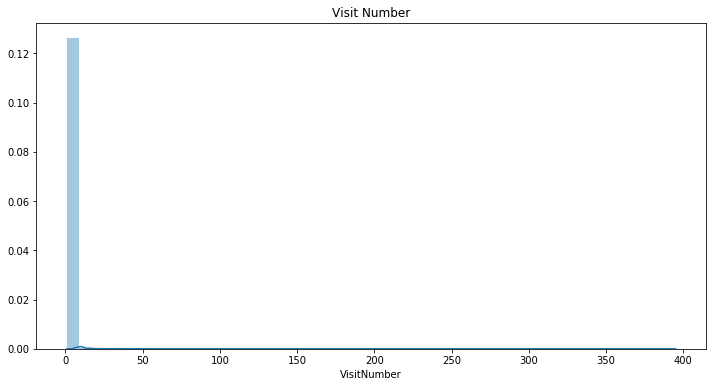

In [0]:
a = train.groupby("fullVisitorId")["visitNumber"].max()
plt.figure(figsize=[12, 6])
sns.distplot(a)
plt.xlabel('VisitNumber')
plt.title('Visit Number')
plt.show()

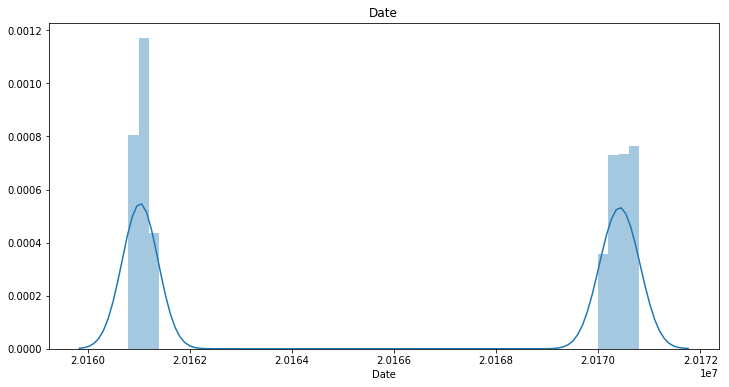

In [0]:
plt.figure(figsize=[12, 6])
sns.distplot(train['date'])
plt.xlabel('Date')
plt.title('Date')
plt.show()

### Predictor Variables Correlation Heat Map ###

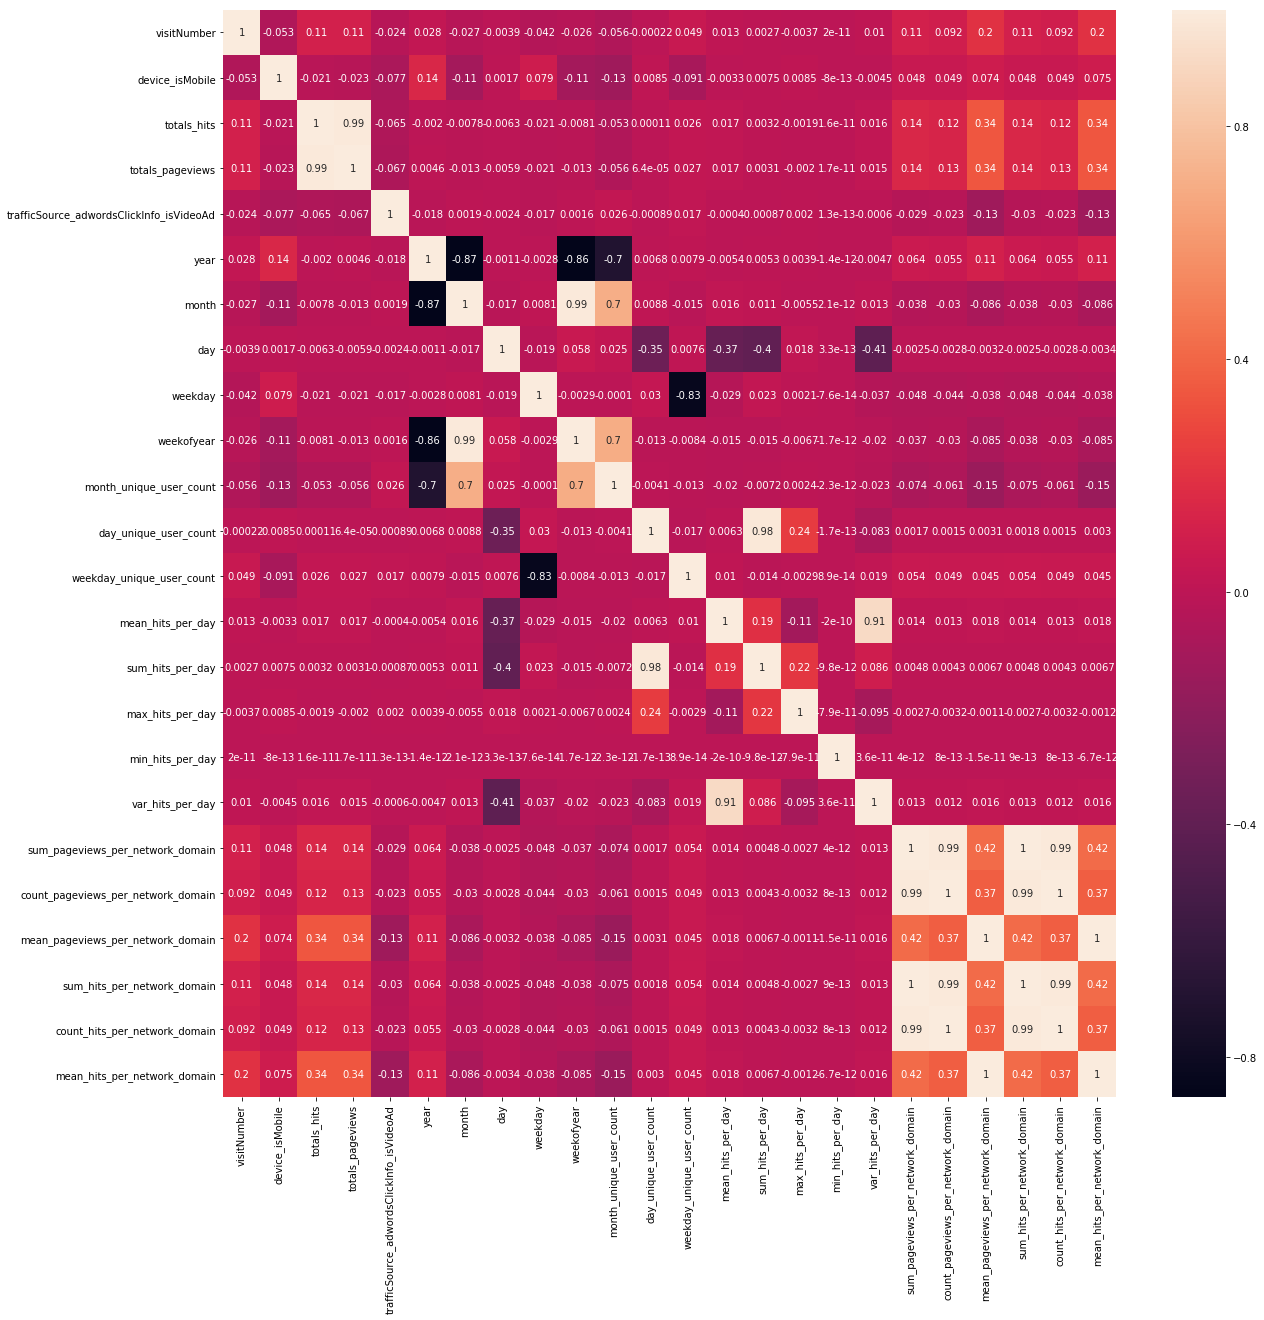

In [0]:
#Built this heat map after data pre-processing but keeping here as it more relevant to EDA#
plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(),annot=True)

### Correlation of Numeric Attributes in Dataset ###

['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'visitNumber', 'totals_hits', 'totals_pageviews', 'mean_hits_per_day', 'sum_hits_per_day', 'min_hits_per_day', 'max_hits_per_day', 'var_hits_per_day', 'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain', 'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain']


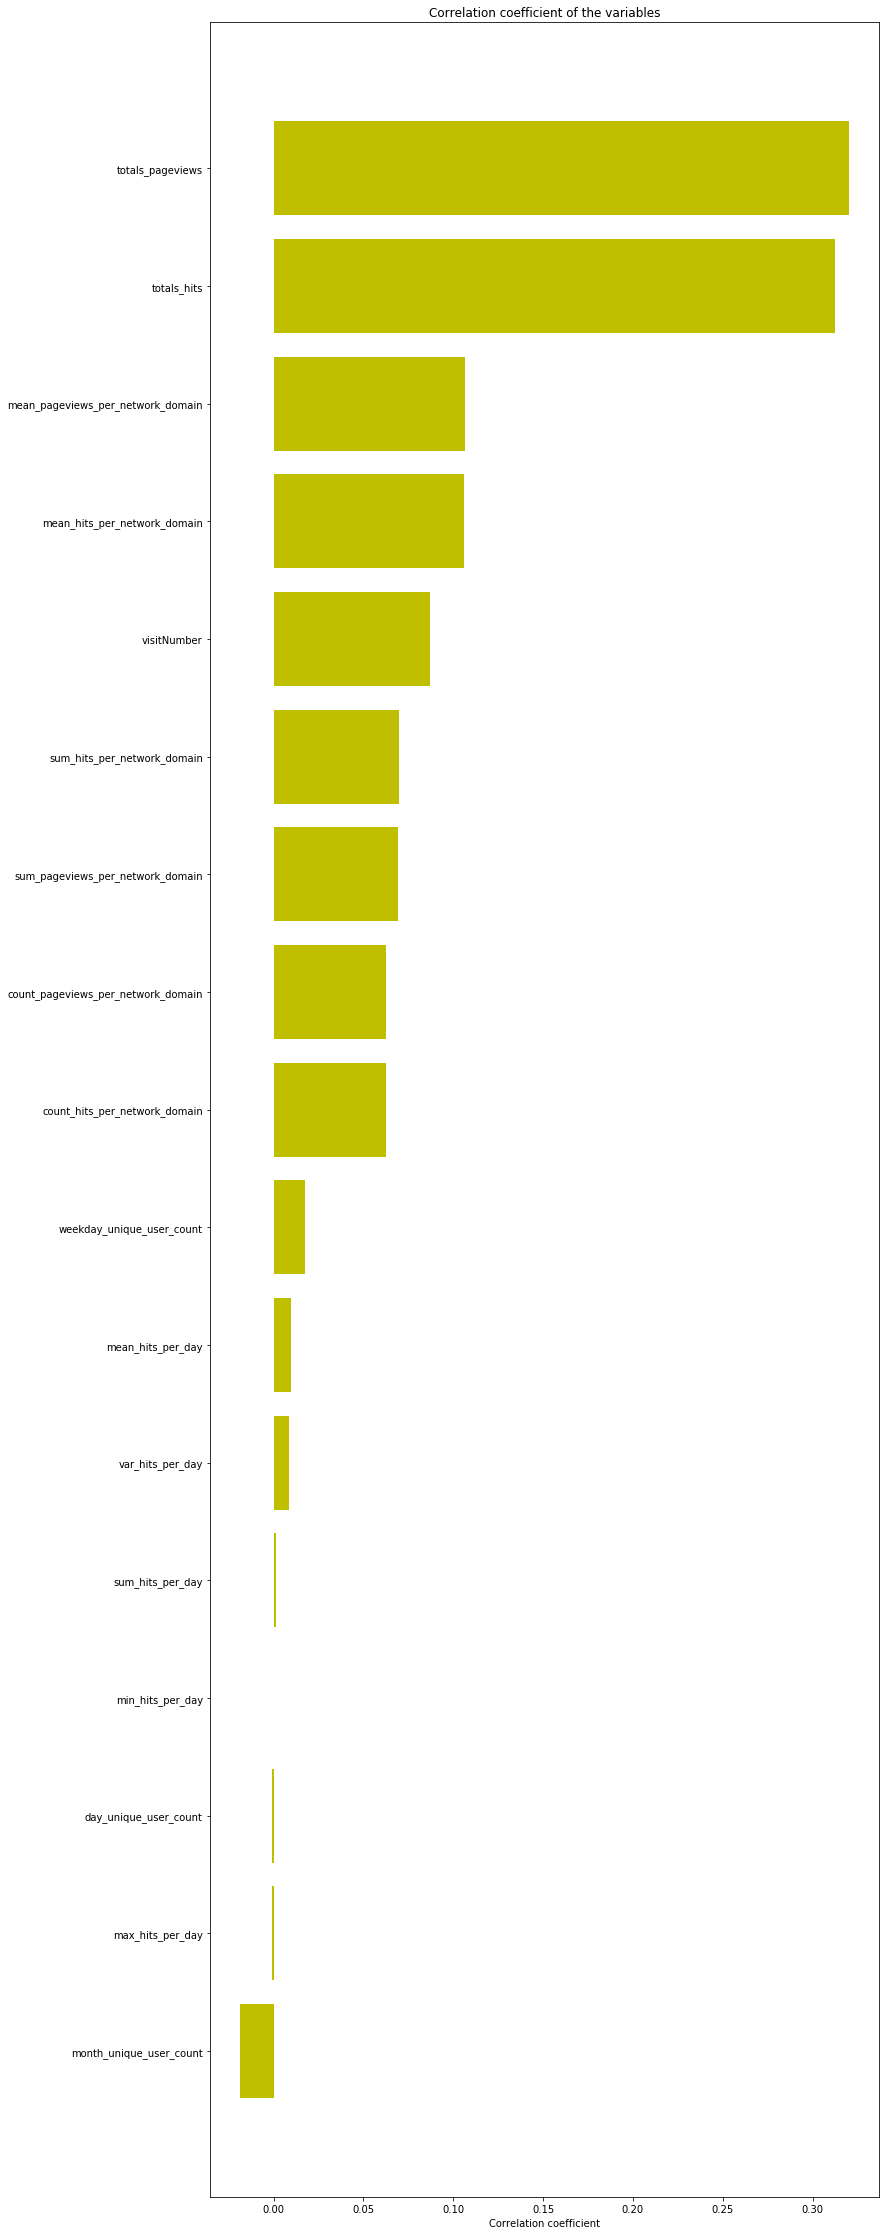

In [0]:
train_df_new = X_train[num_cols].copy()
train_df_new_y = y_train.copy()

#print(train_df_new.head())

#Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['totals_transactionRevenue']]

print(x_cols)
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new_y.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

### Column mismatch between Train and Test ###

In [0]:
set(train.columns).difference(set(test.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

### Columns that may not be needed ###

In [5]:
cons_col = [i for i in train.columns if train[i].nunique(dropna=False)==1]
cons_col

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [0]:
not_used_cols = ["date","fullVisitorId","sessionId", "visitId", "visitStartTime", "trafficSource_referralPath"]

### Outlier - To be dropped ###

In [0]:
#AS IDENTIFIED IN EDA COUNTRY Anguilla HAS A VERY HIGH VALUE SINGLE VISIT TRANSACTION
print('Dropping following observation:')
outlier_index = train[train["geoNetwork.country"]=='Anguilla'].index
display(train[train["geoNetwork.country"]=='Anguilla'])
#train.drop(outlier_index,axis=0,inplace=True)

Dropping following observation:


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
433234,Organic Search,20170208,0403377724115575972,0403377724115575972_1486571908,Not Socially Engaged,1486571908,1,1486571908,Safari,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


### Check Missing values ###

In [0]:
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
train_missing = find_missing(train_cpy)
test_missing = find_missing(test_cpy)

train_missing.reset_index()[['index', 'missing_ratio']]\
    .merge(test_missing.reset_index()[['index', 'missing_ratio']], on='index', how='left')\
    .rename(columns={'index':'columns', 'missing_ratio_x':'train_missing_ratio', 'missing_ratio_y':'test_missing_ratio'})\
    .sort_values(['train_missing_ratio', 'test_missing_ratio'], ascending=False)\
    .query('train_missing_ratio>0')

,columns,train_missing_ratio,test_missing_ratio
49,trafficSource.campaignCode,0.999999,NaN
41,trafficSource.adContent,0.987887,0.933153
39,totals.transactionRevenue,0.987257,NaN
42,trafficSource.adwordsClickInfo.adNetworkType,0.976252,0.933124
45,trafficSource.adwordsClickInfo.isVideoAd,0.976252,0.933124
46,trafficSource.adwordsClickInfo.page,0.976252,0.933124
47,trafficSource.adwordsClickInfo.slot,0.976252,0.933124
44,trafficSource.adwordsClickInfo.gclId,0.976140,0.933064
50,trafficSource.isTrueDirect,0.696781,0.676254
53,trafficSource.referralPath,0.633774,0.707558


## Data Pre-Processing and Feature Engineering ##

### Helper Classes for Pre-processing and Feature Engineering ###

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.cat_cols=cat_cols
        return None
    def fit(self, X, y=None):
        self.X=X
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        X.columns = self.cat_cols
        for col in self.cat_cols:
            lbl = LabelEncoder()
            lbl.fit(list(X[col].values.astype('str')))
            X[col] = lbl.transform(list(X[col].values.astype('str')))
        return X

### Feature Extraction Functions ###

In [0]:
def process_date_time(data_df):
    print("process date time ...")
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    data_df['weekofyear'] = data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    #data_df = data_df.drop(['date','fullVisitorId'], axis=1,inplace=True)
    return data_df

def process_format(data_df):
    print("process format ...")
    for col in ['visitNumber', 'totals_hits', 'totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
    data_df['trafficSource_adwordsClickInfo_isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df

def process_device(data_df):
    print("process device ...")
    data_df['browser_category']        = data_df['device_browser'] + '_' + data_df['device_deviceCategory']
    data_df['browser_operatingSystem'] = data_df['device_browser'] + '_' + data_df['device_operatingSystem']
    data_df['source_country']          = data_df['trafficSource_source'] + '_' + data_df['geoNetwork_country']
    return data_df
    
def process_totals(data_df):
    print("process totals ...")
    data_df['visitNumber']       = np.log1p(data_df['visitNumber'])
    data_df['totals_hits']       = np.log1p(data_df['totals_hits'])
    data_df['totals_pageviews']  = np.log1p(data_df['totals_pageviews'].fillna(0))
    data_df['mean_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('max')
    data_df['min_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('min')
    data_df['var_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('var')
    return data_df

def process_geo_network(data_df):
    print("process geo network ...")
    data_df['sum_pageviews_per_network_domain']   = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain']  = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain']        = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain']      = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain']       = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    return data_df

### Pre-processing and Feature Engineering Orchestrator Class ###

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
class AttributesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X, y=None):
        print("Fitting Data...")
        return self  # nothing else to do
    def transform(self, X, y=None):
        print("Transforming Data...")
        
        #Impute train
        X['totals_newVisits'].fillna(0,inplace=True) 
        X['totals_bounces'].fillna(0,inplace=True)
        X['trafficSource_adwordsClickInfo_page'].fillna(0,inplace=True)
        X['trafficSource_isTrueDirect'].replace({np.nan:0,'true':1},inplace=True)
        X['totals_bounces']   = X['totals_bounces'].fillna(0.0)
        X['totals_newVisits'] = X['totals_newVisits'].fillna(0.0)
        
        #Feature Engineering
        X = process_date_time(X)
        X = process_format(X)
        X = process_device(X)
        X = process_totals(X)
        X = process_geo_network(X)
        
        #Drop Columns
        cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1 and 
                        col not in ['totals_transactionRevenue','date']]
        X.drop(cols_to_drop, axis=1, inplace=True)
    
        #Column with mostly NULL value and only one NOT NULL value
        if 'trafficSource_campaign' in X.columns:
             X.drop(['trafficSource_campaign'], axis=1, inplace=True)
    
        #Drop Outlier
        #X.drop(train_df[train_df["geoNetwork_country"]=='Anguilla'].index,axis=0,inplace=True)
        
        #Drop unused columns
        X.drop(not_used_cols,axis=1,inplace=True)
        print("Exit") 
        return X

### Prepare the Data ###

In [0]:
train_df = train.copy()
train_df.columns = train_df.columns.str.replace(".","_")
train_df = train_df.sort_values('date')

#Prepare Target Variable
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0)
train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])
X_train = train_df.drop('totals_transactionRevenue',axis=1)
y_train = train_df['totals_transactionRevenue']

### Invoke Orchestrator Class ###

In [12]:
X_train = AttributesPreprocessor().fit_transform(X_train,y_train)

Fitting Data...
Transforming Data...
process date time ...
process format ...
process device ...
process totals ...
process geo network ...
Exit


### Split the data using Sklearn ###

In [0]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Build the Full Pipeline ###

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count','visitNumber', 'totals_hits', 'totals_pageviews', 
            'mean_hits_per_day', 'sum_hits_per_day', 'min_hits_per_day', 'max_hits_per_day', 'var_hits_per_day',
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain']
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1 and  col not in ['totals_transactionRevenue','date']]
cat_cols     = [col for col in X_train.columns if col not in num_cols and  col not in not_used_cols and col not in cols_to_drop and col not in 'trafficSource_campaign']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
        #('std_scaler', StandardScaler())
        ('std_scaler', MinMaxScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_cols)),
        ('cat_encoder', CategoricalEncoder(cat_cols))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

### Model Building and Cross Validation using Grid Search ###

#### Linear Regression Model ####

##### Model Pipeline #####

In [0]:
from sklearn.linear_model import LinearRegression
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("linRegression", LinearRegression())
])

prepare model...


##### Grid Search and Fit Data #####

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'linRegression__fit_intercept'     : [True,False],
    'linRegression__n_jobs'            : [-1]
}
grid_search_prep_LR = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_LR.fit(X_train_split, y_train_split)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] linRegression__fit_intercept=True, linRegression__n_jobs=-1 .....
[CV] linRegression__fit_intercept=True, linRegression__n_jobs=-1 .....
[CV] linRegression__fit_intercept=True, linRegression__n_jobs=-1 .....
[CV] linRegression__fit_intercept=True, linRegression__n_jobs=-1 .....
[CV]  linRegression__fit_intercept=True, linRegression__n_jobs=-1, total= 2.6min
[CV]  linRegression__fit_intercept=True, linRegression__n_jobs=-1, total= 2.8min
[CV] linRegression__fit_intercept=True, linRegression__n_jobs=-1 .....
[CV]  linRegression__fit_intercept=True, linRegression__n_jobs=-1, total= 2.7min
[CV]  linRegression__fit_intercept=True, linRegression__n_jobs=-1, total= 2.5min
[CV] linRegression__fit_intercept=False, linRegression__n_jobs=-1 ....
[CV] linRegression__fit_intercept=False, linRegression__n_jobs=-1 ....
[CV] linRegression__fit_intercept=False, linRegression__n_jobs=-1 ....
[CV]  linRegression__fit_intercept=True, linRegr

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'visitNumber', 'totals_hits', 'totals_pageviews',...)), ('linRegression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'linRegression__fit_intercept': [True, False], 'linRegression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

##### Grid Search Results #####

In [0]:
pd.DataFrame(grid_search_prep_LR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linRegression__fit_intercept,param_linRegression__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,124.966070,10.648536,27.791461,1.514120,True,-1,"{'linRegression__fit_intercept': True, 'linReg...",-3.481782,-3.50172,-3.402278,...,-3.435390,0.046731,1,-3.413887,-3.406323,-3.436833,-3.432224,-3.437719,-3.425397,0.012849
1,104.303695,10.576737,24.323098,3.828627,False,-1,"{'linRegression__fit_intercept': False, 'linRe...",-3.502501,-3.50172,-3.402278,...,-3.439534,0.051351,2,-3.413887,-3.406323,-3.436833,-3.432224,-3.437719,-3.425397,0.012849


##### Predict using Best LR Model #####

In [0]:
results = pd.DataFrame(columns=["Model description", "Best Params", "Best RMSE Score", "Train RMSE","Test RMSE", "Train Time", "Test Time"])
pd.set_option('display.max_colwidth', 0)

import time
start = time.time()
grid_search_prep_LR.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_LR.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_LR.best_estimator_.predict(X_test_split)
test_time = time.time() - start

# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Linear Regression Best Model",
                            grid_search_prep_LR.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_LR.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.853,1.851,1.85,223.962575,31.846963


#### Random Forest Regressor ####

##### Model Pipeline #####

In [0]:
from sklearn.ensemble import RandomForestRegressor
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("RFRegression", RandomForestRegressor())
])

prepare model...


##### Grid Search and Fit Data #####

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'RFRegression__n_estimators'      : [50,100],
    'RFRegression__max_depth'         : [8, 9, 10],
    'RFRegression__random_state'      : [0,1]
}
grid_search_prep_RF = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_RF.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=0 
[CV] RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=0 
[CV] RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=0 
[CV] RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=1 
[CV]  RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=0, total= 6.7min
[CV]  RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=0, total= 6.4min
[CV] RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=1 
[CV]  RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=0, total= 6.6min
[CV] RFRegression__max_depth=8, RFRegression__n_estimators=50, RFRegression__random_state=1 
[CV]  RFRegression__max_depth=8, RFRegression__n_estimato

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 97.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'visitNumber', 'totals_hits', 'totals_pageviews',...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'RFRegression__n_estimators': [50, 100], 'RFRegression__max_depth': [8, 9, 10], 'RFRegression__random_state': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

##### Grid Search Results #####

In [0]:
pd.DataFrame(grid_search_prep_LR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linRegression__fit_intercept,param_linRegression__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,124.966070,10.648536,27.791461,1.514120,True,-1,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",-3.481782,-3.50172,-3.402278,...,-3.435390,0.046731,1,-3.413887,-3.406323,-3.436833,-3.432224,-3.437719,-3.425397,0.012849
1,104.303695,10.576737,24.323098,3.828627,False,-1,"{'linRegression__fit_intercept': False, 'linRegression__n_jobs': -1}",-3.502501,-3.50172,-3.402278,...,-3.439534,0.051351,2,-3.413887,-3.406323,-3.436833,-3.432224,-3.437719,-3.425397,0.012849


##### Predict using Best RF Model #####

In [0]:
import time
start = time.time()
grid_search_prep_RF.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_RF.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_RF.best_estimator_.predict(X_test_split)
test_time = time.time() - start

# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Random Forest Regression Best Model",
                            grid_search_prep_RF.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_RF.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.853,1.851,1.850,223.962575,31.846963
1,SKLearn Random Forest Regression Best Model,"{'RFRegression__max_depth': 10, 'RFRegression__n_estimators': 100, 'RFRegression__random_state': 1}",1.847,1.534,1.887,764.040462,34.156161


#### Xgboost Regressor ####

##### Set Parameters #####

In [0]:
import xgboost as xgb
param = {
    'max_depth': 8,  # the maximum depth of each tree, we tried 8, 10
    'eta': 0.01,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'alpha':0.01,
    'num_leaves' : 40,
    #'eval_sets' : [[X_train_val,y_train_val]],
    'random_state': 42}  

##### Pre-processing Pipeline #####

In [0]:
prepare_select_and_pipeline = Pipeline([
    ('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train_split)
X_test_d=prepare_select_and_pipeline.fit_transform(X_test_split)
feature_names = X_train_split.columns

##### Xgboost Cross Validation #####

In [0]:
import xgboost as xgb
print("prepare model...")
X_train_data = xgb.DMatrix(X_train_d,label=y_train_split,feature_names=feature_names)
xgb_cv_results = xgb.cv(dtrain=X_train_data,params=param, nfold=5, num_boost_round=2500,  early_stopping_rounds=100, metrics="rmse", as_pandas=True, seed=123)
mean_mae = xgb_cv_results['test-rmse-mean'].min()
boost_rounds = xgb_cv_results['test-rmse-mean'].idxmin()
print("\tRMSE {} for {} rounds".format(mean_mae, boost_rounds))

prepare model...
	RMSE 1.6335974 for 368 rounds


##### Model Training using Train & Eval datasets #####

In [0]:
X_train_split_tr, X_train_val, y_train_split_tr, y_train_val = train_test_split(X_train_d, y_train_split, test_size=0.2, random_state=42)
X_train_tr_data = xgb.DMatrix(X_train_split_tr,label=y_train_split_tr,feature_names=feature_names)
X_val_data = xgb.DMatrix(X_train_val,label=y_train_val,feature_names=feature_names)

In [0]:
import time
start = time.time()
xgb_model = xgb.train(param, X_train_tr_data, evals=[(X_train_tr_data, 'train'), (X_val_data, 'valid')], num_boost_round=2500, early_stopping_rounds=800, verbose_eval=1000)
train_time = time.time()-start

[0]	train-rmse:2.00968	valid-rmse:2.03177
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 800 rounds.
[1000]	train-rmse:1.37771	valid-rmse:1.62441
Stopping. Best iteration:
[858]	train-rmse:1.40206	valid-rmse:1.62365



##### Predict Test set and Print CV Results #####

In [0]:
import numpy as np
X_test_data = xgb.DMatrix(X_test_d,label=y_test_split,feature_names=feature_names)
start = time.time()
preds = xgb_model.predict(X_test_data,ntree_limit=xgb_model.best_ntree_limit)
test_time=time.time()-start
preds_train = xgb_model.predict(X_train_tr_data,ntree_limit=xgb_model.best_ntree_limit)
np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3)
results.loc[len(results)] = ["SKLearn Xgboost Regressor Best Model-3",
                            param,
                            np.round(xgb_model.best_score, 3),
                            np.round(np.sqrt(((y_train_split_tr-preds_train)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3),
                            train_time,
                            test_time]

In [0]:
xgb_cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.012195,0.002260,2.014211,0.008885
1,2.003990,0.002309,2.007892,0.008770
2,1.996769,0.004157,2.002441,0.007695
3,1.988856,0.004370,1.996472,0.007438
4,1.980948,0.004192,1.990589,0.007476
5,1.972834,0.004082,1.984537,0.007370
6,1.964849,0.004015,1.978696,0.007368
7,1.957011,0.004306,1.972963,0.007176
8,1.949345,0.004264,1.967333,0.007278
9,1.941544,0.004129,1.961698,0.007381


#### LightGBM Regressor ####

##### Set Parameters #####

In [0]:
params = {'objective' : 'regression', 
          'metric' : 'rmse', 
          'n_estimators': 10000, 
          'early_stopping_rounds': 800,
          'min_data_in_leaf' : 100,
          'num_leaves' : 150, 
          'learning_rate' : 0.01, 
          'bagging_fraction' : 0.80,
          'feature_fraction' : 0.85, 
          'bagging_seed' : 0,
          'colsample_bytree' : 0.9,
          'use_best_model': True}
    

##### Pre-processing Pipeline #####

In [0]:
prepare_select_and_pipeline = Pipeline([
    ('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train_split)
X_test_d=prepare_select_and_pipeline.fit_transform(X_test_split)
#feature_names = X_train_split.columns

##### LightGBM Cross Validation #####

In [0]:
import lightgbm as lgb
print("prepare model...")
X_train_data = lgb.Dataset(X_train_d,label=y_train_split,feature_name=X_train_split.columns.tolist())
lgb_cv_results = lgb.cv(params, X_train_data, nfold=5, num_boost_round=5000, metrics="rmse",stratified=False)
mean_mae = pd.DataFrame(lgb_cv_results['rmse-mean']).min()
boost_rounds = pd.DataFrame(lgb_cv_results['rmse-mean']).idxmin()
print("\tRMSE {} for {} rounds".format(mean_mae, boost_rounds))

prepare model...
	RMSE 0    1.620603
dtype: float64 for 0    566
dtype: int64 rounds


##### Model Training using Train & Eval datasets #####

In [0]:
X_train_split_tr, X_train_val, y_train_split_tr, y_train_val = train_test_split(X_train_d, y_train_split, test_size=0.2, random_state=42)
X_train_tr_data = lgb.Dataset(X_train_split_tr,label=y_train_split_tr,feature_name=X_train_split.columns.tolist())
X_val_data = lgb.Dataset(X_train_val,label=y_train_val,feature_name=X_train_split.columns.tolist())

In [0]:
import time
start = time.time()
lgb_model = lgb.train(params, X_train_tr_data, valid_sets=[X_val_data], num_boost_round=10000, verbose_eval=1000)
train_time = time.time()-start

Training until validation scores don't improve for 800 rounds.
[1000]	valid_0's rmse: 1.62897
Early stopping, best iteration is:
[529]	valid_0's rmse: 1.62325


##### Predict Test set and Print CV Results #####

In [0]:
import numpy as np
X_test_data = lgb.Dataset(X_test_d,label=y_test_split,feature_name=X_train_split.columns.tolist())
start = time.time()
preds = lgb_model.predict(X_test_d,num_iteration=lgb_model.best_iteration)
test_time=time.time()-start
preds_train = lgb_model.predict(X_train_split_tr, num_iteration=lgb_model.best_iteration)
np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3)
results.loc[len(results)] = ["LightGBM Regressor Best Model-3",
                             params,
                             np.round(lgb_model.best_score['valid_0']['rmse'], 3),
                             np.round(np.sqrt(((y_train_split_tr-preds_train)**2).mean()), 3),
                             np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3),
                             train_time,
                             test_time]

#### Lasso Regression ####

##### Model Pipeline #####

In [0]:
from sklearn.linear_model import Lasso
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("lassoregress", Lasso())
])

prepare model...


##### Grid Search and Fit Data #####

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {
#    'lassoregress__fit_intercept'     : [True,False],
    'lassoregress__alpha'             : [0.001, 0.01, 0.1],
    'lassoregress__max_iter'          : [1000]
}
grid_search_prep_LS = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_LS.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] lassoregress__alpha=0.001, lassoregress__max_iter=1000 ..........
[CV] lassoregress__alpha=0.001, lassoregress__max_iter=1000 ..........
[CV] lassoregress__alpha=0.001, lassoregress__max_iter=1000 ..........
[CV] lassoregress__alpha=0.01, lassoregress__max_iter=1000 ...........
[CV]  lassoregress__alpha=0.001, lassoregress__max_iter=1000, total= 9.3min
[CV] lassoregress__alpha=0.01, lassoregress__max_iter=1000 ...........
[CV]  lassoregress__alpha=0.001, lassoregress__max_iter=1000, total= 9.2min
[CV]  lassoregress__alpha=0.001, lassoregress__max_iter=1000, total= 9.9min
[CV] lassoregress__alpha=0.01, lassoregress__max_iter=1000 ...........
[CV] lassoregress__alpha=0.1, lassoregress__max_iter=1000 ............
[CV]  lassoregress__alpha=0.01, lassoregress__max_iter=1000, total= 9.7min
[CV] lassoregress__alpha=0.1, lassoregress__max_iter=1000 ............
[CV]  lassoregress__alpha=0.01, lassoregress__max_iter=1000, total= 7.

[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 22.9min remaining:  6.5min


[CV]  lassoregress__alpha=0.1, lassoregress__max_iter=1000, total= 7.0min
[CV]  lassoregress__alpha=0.1, lassoregress__max_iter=1000, total= 2.8min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 26.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'visitNumber', 'totals_hits', 'totals_pageviews',...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lassoregress__alpha': [0.001, 0.01, 0.1], 'lassoregress__max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

##### Grid Search Results #####

In [0]:
pd.DataFrame(grid_search_prep_LS.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lassoregress__alpha,param_lassoregress__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,493.720864,23.790285,76.454695,7.840424,0.001,1000,"{'lassoregress__alpha': 0.001, 'lassoregress__max_iter': 1000}",-3.410226,-3.428493,-3.430498,-3.423072,0.009121,1,-3.427976,-3.416343,-3.415425,-3.419915,0.005713
1,424.019513,71.775652,76.653359,21.138017,0.01,1000,"{'lassoregress__alpha': 0.01, 'lassoregress__max_iter': 1000}",-3.415767,-3.442837,-3.447118,-3.435240,0.013880,2,-3.440507,-3.428413,-3.428357,-3.432426,0.005715
2,289.829989,111.253031,50.356791,10.728625,0.1,1000,"{'lassoregress__alpha': 0.1, 'lassoregress__max_iter': 1000}",-3.565336,-3.596699,-3.615029,-3.592355,0.020518,3,-3.599909,-3.585301,-3.581237,-3.588816,0.008018


##### Predict using Best Lasso Model #####

In [0]:
import time
start = time.time()
grid_search_prep_LS.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_LS.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_LS.best_estimator_.predict(X_test_split)
test_time = time.time() - start
# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Lasso Regression Best Model",
                            grid_search_prep_LS.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_LS.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]

#### Ridge Regressor ####

##### Model Pipeline #####

In [0]:
from sklearn.linear_model import Ridge
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("ridgeregress", Ridge())
])

prepare model...


##### Grid Search and Fit Data #####

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {
#    'lassoregress__fit_intercept'     : [True,False],
    'ridgeregress__alpha'             : [0.1],
    'ridgeregress__max_iter'          : [1000],
    'ridgeregress__solver'            : ['auto']
}
grid_search_prep_RR = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_RR.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] ridgeregress__alpha=0.1, ridgeregress__max_iter=1000, ridgeregress__solver=auto 
[CV] ridgeregress__alpha=0.1, ridgeregress__max_iter=1000, ridgeregress__solver=auto 
[CV] ridgeregress__alpha=0.1, ridgeregress__max_iter=1000, ridgeregress__solver=auto 
[CV]  ridgeregress__alpha=0.1, ridgeregress__max_iter=1000, ridgeregress__solver=auto, total= 2.2min
[CV]  ridgeregress__alpha=0.1, ridgeregress__max_iter=1000, ridgeregress__solver=auto, total= 2.2min
[CV]  ridgeregress__alpha=0.1, ridgeregress__max_iter=1000, ridgeregress__solver=auto, total= 2.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'visitNumber', 'totals_hits', 'totals_pageviews',...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridgeregress__alpha': [0.1], 'ridgeregress__max_iter': [1000], 'ridgeregress__solver': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

##### Grid Search Results #####

In [0]:
pd.DataFrame(grid_search_prep_RR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridgeregress__alpha,param_ridgeregress__max_iter,param_ridgeregress__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,86.51297,2.793323,45.699987,2.719655,0.1,1000,auto,"{'ridgeregress__alpha': 0.1, 'ridgeregress__max_iter': 1000, 'ridgeregress__solver': 'auto'}",-3.407063,-3.444043,-3.463652,-3.438252,0.023463,1,-3.427049,-3.415432,-3.414637,-3.419039,0.005673


##### Predict using Best Ridge Model #####

In [0]:
import time
start = time.time()
grid_search_prep_RR.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_RR.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_RR.best_estimator_.predict(X_test_split)
test_time = time.time() - start
# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Ridge Regression Best Model-3",
                            grid_search_prep_RR.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_RR.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]

#### Keras Deep Learning Model ####

In [0]:
from keras import models
from keras import optimizers
from keras.models import *
from keras.layers.recurrent import LSTM
from keras.layers import Input, Dense, Activation, Reshape, Concatenate, Flatten, concatenate
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

##### Set up the Pipeline #####

In [0]:
results_dl = pd.DataFrame(columns=["Model description", "Best Params", "Best RMSE Score", "Train RMSE","Test RMSE", "Train Time", "Test Time"])
pd.set_option('display.max_colwidth', 0)

In [0]:
from sklearn.model_selection import train_test_split
prepare_select_and_pipeline = Pipeline([('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_d, y_train, test_size=0.1, random_state=42)

##### Build the Model - Sequential API #####

In [53]:
model = Sequential()
model.add(Dense(100,activation='relu',input_dim=X_train_split.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(200,activation='relu',kernel_initializer='normal'))
model.add(Dense(300,activation='relu',kernel_initializer='normal'))
model.add(Dense(1,activation='linear',kernel_initializer='normal'))
model.compile(loss='mse',metrics=['mse'],optimizer='adam')
start = time.time()
model.fit(X_train_split,y_train_split,epochs=10, batch_size=32, verbose = 1)
train_time = time.time() - start

Epoch 1/10
813287/813287 [==============================] - 71s 87us/step - loss: 18691.6596 - mean_squared_error: 18691.6596
Epoch 2/10
813287/813287 [==============================] - 71s 87us/step - loss: 52.5356 - mean_squared_error: 52.5356
Epoch 3/10
813287/813287 [==============================] - 70s 86us/step - loss: 8.6214 - mean_squared_error: 8.6214
Epoch 4/10
813287/813287 [==============================] - 71s 87us/step - loss: 14.7375 - mean_squared_error: 14.7375
Epoch 5/10
813287/813287 [==============================] - 70s 86us/step - loss: 9.1920 - mean_squared_error: 9.1920
Epoch 6/10
813287/813287 [==============================] - 69s 85us/step - loss: 7.2373 - mean_squared_error: 7.2373
Epoch 7/10
813287/813287 [==============================] - 70s 86us/step - loss: 4.9490 - mean_squared_error: 4.9490
Epoch 8/10
813287/813287 [==============================] - 72s 89us/step - loss: 4.8904 - mean_squared_error: 4.8904
Epoch 9/10
813287/813287 [==================

##### Build the Model - Functional API #####

In [68]:
inp=Input(shape=(51,))
hidden1=Dense(51,activation="relu")(inp)
hidden2=Dense(60,activation="relu")(hidden1)
hidden3=Dense(70,activation="relu")(hidden2)
hidden4=Dense(80,activation="relu")(hidden3)
hidden5=Dense(90,activation="relu")(hidden4)
hidden6=Dense(100,activation="relu")(hidden5)
hidden7=Dense(110,activation="relu")(hidden6)
hidden8=Dense(120,activation="relu")(hidden7)
output=Dense(1,activation="linear")(hidden8)
model_mlp=Model(inputs=[inp],outputs=[output])
model_mlp.compile(loss='mse',optimizer='adagrad',metrics=['mae'])
start = time.time()
model_mlp.fit(X_train_split,y_train_split,epochs=15, batch_size=64,verbose = 1)
train_time = time.time() - start

Epoch 1/15
813287/813287 [==============================] - 37s 45us/step - loss: 176124.5129 - mean_absolute_error: 6.4495
Epoch 2/15
813287/813287 [==============================] - 35s 43us/step - loss: 7.3018 - mean_absolute_error: 1.3763
Epoch 3/15
813287/813287 [==============================] - 35s 43us/step - loss: 5.3169 - mean_absolute_error: 1.1139
Epoch 4/15
813287/813287 [==============================] - 35s 43us/step - loss: 5.0582 - mean_absolute_error: 1.0288
Epoch 5/15
813287/813287 [==============================] - 35s 43us/step - loss: 4.9165 - mean_absolute_error: 0.9733
Epoch 6/15
813287/813287 [==============================] - 35s 42us/step - loss: 4.8178 - mean_absolute_error: 0.9308
Epoch 7/15
813287/813287 [==============================] - 34s 42us/step - loss: 4.7373 - mean_absolute_error: 0.8969
Epoch 8/15
813287/813287 [==============================] - 34s 42us/step - loss: 4.6694 - mean_absolute_error: 0.8683
Epoch 9/15
813287/813287 [=================

##### Predict Test Set #####

In [0]:
start = time.time()
y_test_pred = model.predict(X_test_split).flatten()
test_time = time.time() - start

In [0]:
start = time.time()
y_train_pred = model.predict(X_train_split).flatten()
test_time = time.time() - start

In [0]:
start = time.time()
y_test_pred = model_mlp.predict(X_test_split).flatten()
test_time = time.time() - start

In [0]:
start = time.time()
y_train_pred = model_mlp.predict(X_train_split).flatten()
test_time = time.time() - start

##### Log Results #####

In [0]:
results_dl.loc[len(results_dl)] = ["Deep Learning Model-5",
                            "loss='mse',metrics='mae',optimizer='adagrad',epochs=15,batch_size=64",
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]

## Feature Importance ##

### Random Forest Regressor ###

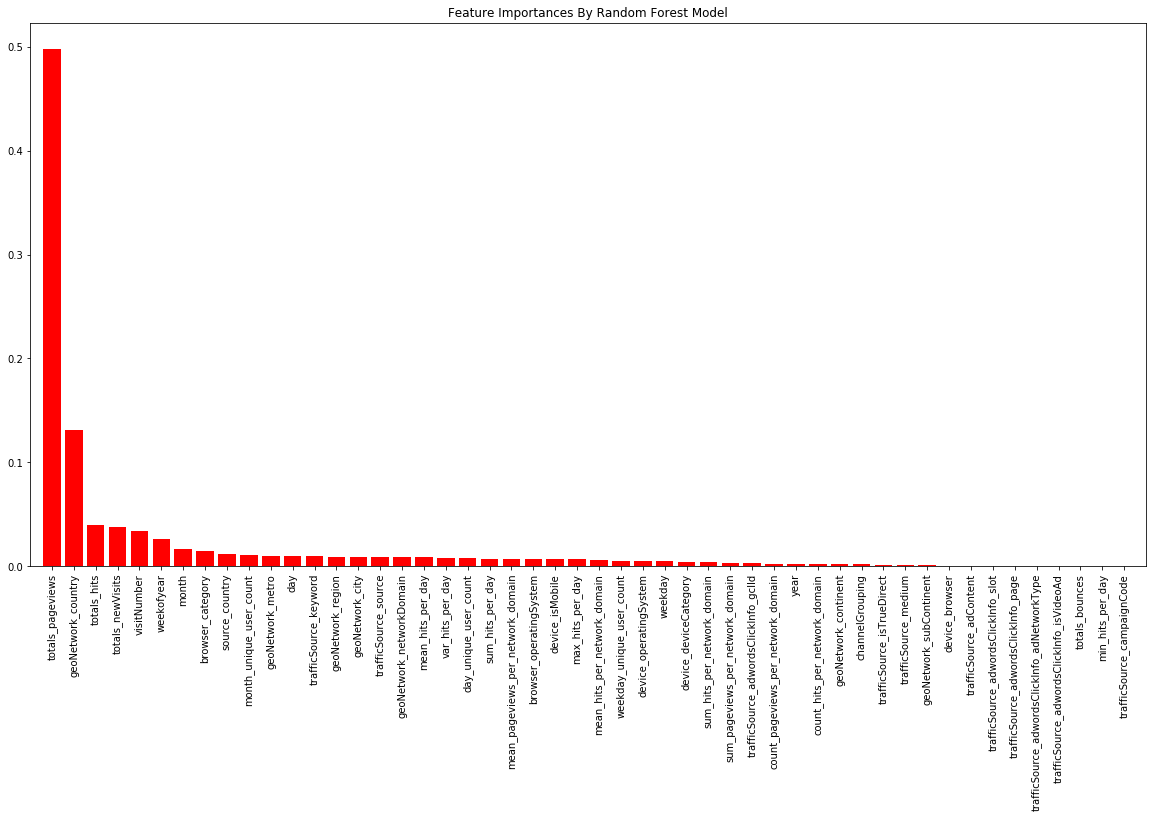

In [0]:
importances=grid_search_prep_RF.best_estimator_.named_steps.RFRegression.feature_importances_
imp_con = np.array(importances[0:50])
std = np.std([imp_con for tree in grid_search_prep_RF.best_estimator_.named_steps.RFRegression.estimators_],
             axis=0)
indices = np.argsort(imp_con)[::-1]
sorted_important_features=[]
predictors=list(num_cols+cat_cols)
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(20,10))
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), imp_con[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

### Xgboost Regressor ###

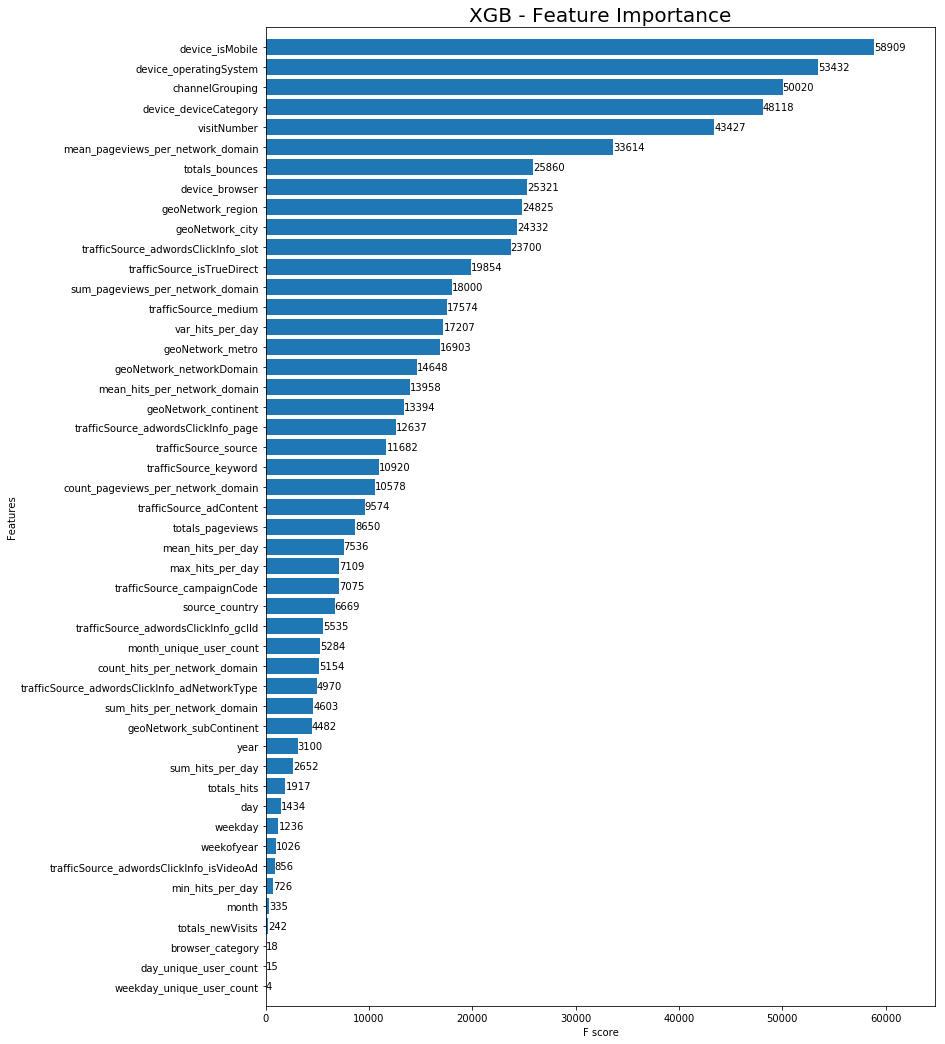

In [0]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
#X_train_data.feature_names
#xgb_model.get_fscore()
#mapper = {'f{0}'.format(i): v for i, v in enumerate(X_train_data.feature_names)}
#mapped = {mapper[k]: v for k, v in xgb_model.get_fscore().items()}
xgb.plot_importance(xgb_model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("XGB - Feature Importance", fontsize=20)
plt.show()

### LightGBM Regressor ###

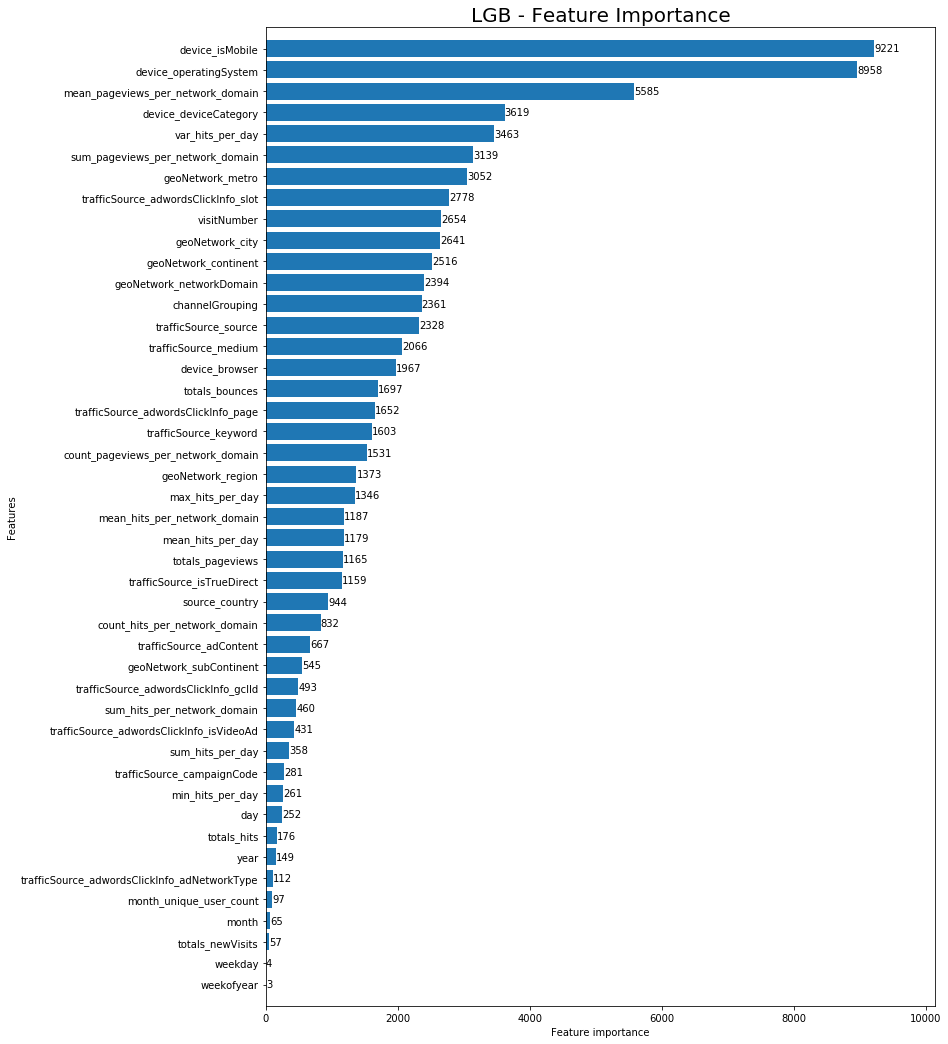

In [0]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
#X_train_data.feature_names
#xgb_model.get_fscore()
#mapper = {'f{0}'.format(i): v for i, v in enumerate(X_train_data.feature_names)}
#mapped = {mapper[k]: v for k, v in xgb_model.get_fscore().items()}
lgb.plot_importance(lgb_model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LGB - Feature Importance", fontsize=20)
plt.show()

### Lasso Regressor ###

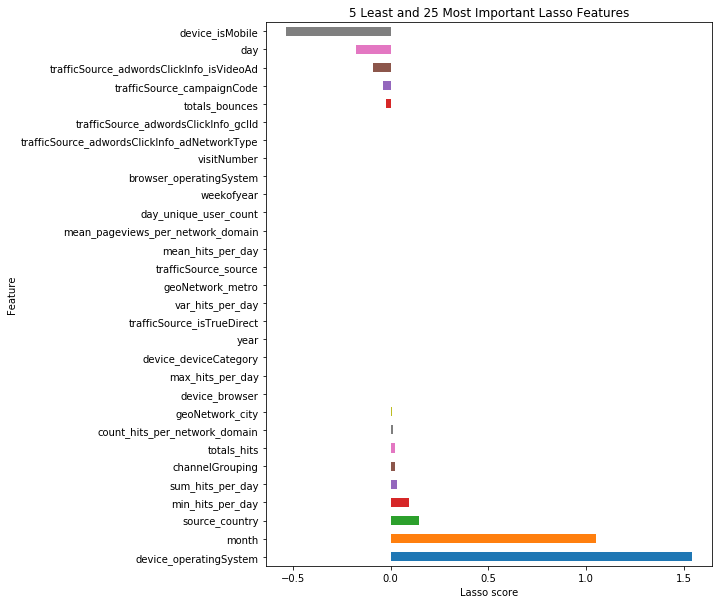

In [0]:
coef = pd.DataFrame(grid_search_prep_LS.best_estimator_.named_steps['lassoregress'].coef_, columns = ['Lasso_score'])
coef['Feature'] = X_train_split.columns
coef = coef.sort_values('Lasso_score', ascending=False)
coef = coef[['Feature', 'Lasso_score']]
imp_coef = pd.concat((coef.head(25), coef.tail(5)))
imp_coef.plot(kind = "barh", x='Feature', y='Lasso_score', legend=False, figsize=(8, 10))
plt.title('5 Least and 25 Most Important Lasso Features')
plt.xlabel('Lasso score')
#plt.savefig('feature_importance_larslassocv.png', bbox_inches='tight', pad_inches=0.5)
plt.show(block=False)

### Ridge Regressor ###

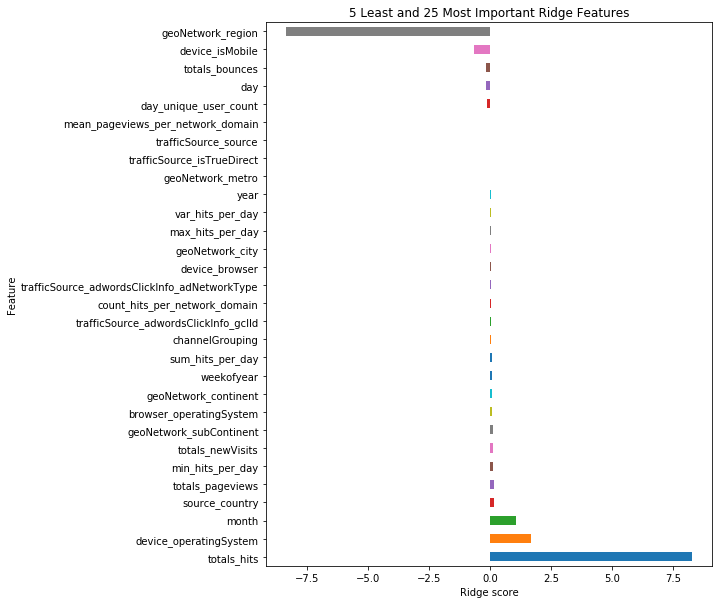

In [0]:
coef = pd.DataFrame(grid_search_prep_RR.best_estimator_.named_steps['ridgeregress'].coef_, columns = ['Ridge_score'])
coef['Feature'] = X_train_split.columns
coef = coef.sort_values('Ridge_score', ascending=False)
coef = coef[['Feature', 'Ridge_score']]
imp_coef = pd.concat((coef.head(25), coef.tail(5)))
imp_coef.plot(kind = "barh", x='Feature', y='Ridge_score', legend=False, figsize=(8, 10))
plt.title('5 Least and 25 Most Important Ridge Features')
plt.xlabel('Ridge score')
#plt.savefig('feature_importance_larslassocv.png', bbox_inches='tight', pad_inches=0.5)
plt.show(block=False)

## Significance Test ##

In [0]:
from sklearn.model_selection import cross_val_score
import numpy as np
from scipy import stats

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 
# it randomly splits the training set into K distinct subsets (k=30)
# this bakeoff framework can be used for regression or classification
#Control system is a logistic regression based pipeline

kFolds=10
lr_scores = cross_val_score(grid_search_prep_LR.best_estimator_, X_train_split, y_train_split,
                             scoring="neg_mean_squared_error", cv=kFolds)
control = lr_rmse_scores = np.sqrt(-lr_scores)
display_scores(lr_rmse_scores)

#Treatment system is a Random Forest based pipeline
rf_scores = cross_val_score(grid_search_prep_RF.best_estimator_, X_train_split, y_train_split,
                         scoring="neg_mean_squared_error", cv=kFolds)
treatment = rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if p_value > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

The p-value is 0.56479 for a t-score of -0.59767.
There is no significant difference between the two machine learning pipelines (Accept H0)


In [0]:
display_scores(lr_rmse_scores)

Scores: [1.9932407  1.84269572 1.46782708 1.50368133 2.09670702 1.769173
 1.81604547 2.06307458 2.01019492 1.93589709]
Mean: 1.8498536913279904
Standard deviation: 0.20821997124644154


In [0]:
display_scores(rf_rmse_scores)

Scores: [2.04443339 1.98685822 1.46127341 1.48112891 2.06752513 1.77735849
 1.78486809 2.08721013 1.98577527 1.92394469]
Mean: 1.860037573335071
Standard deviation: 0.21902254541744978


In [0]:
from sklearn.model_selection import cross_val_score
import numpy as np
from scipy import stats

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 
# it randomly splits the training set into K distinct subsets (k=30)
# this bakeoff framework can be used for regression or classification
#Control system is a lasso regression based pipeline

kFolds=2
ls_scores = cross_val_score(grid_search_prep_LS.best_estimator_, X_train_split, y_train_split,
                             scoring="neg_mean_squared_error", cv=kFolds)
control = ls_rmse_scores = np.sqrt(-ls_scores)
display_scores(ls_rmse_scores)

#Treatment system is a Xgboost Regressor based pipeline
from sklearn.model_selection import cross_val_score
xgb_model2 = xgb.XGBRegressor(max_depth=8,learning_rate=0.01,objective='reg:linear',subsample=0.6,num_leaves=40,colsample_bytree=0.8,eval_metric='rmse',alpha=0.01,random_state=42)
xg_scores = cross_val_score(xgb_model2, X_train_d, y_train_split,
                            scoring="neg_mean_squared_error", cv=2)
treatment = xg_rmse_scores = np.sqrt(-xg_scores)
display_scores(xg_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if p_value > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

Scores: [1.85008937 1.84961344]
Mean: 1.8498514049060213
Standard deviation: 0.00023796146475085767
Scores: [1.71571122 1.71417187]
Mean: 1.7149415436895048
Standard deviation: 0.0007696757643069763
The p-value is 0.00251 for a t-score of 253.72622.
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (253.73, 0.00251)
Machine learning pipeline B is better than A


## Final Results and Discussion ##

<h3> Model Pipeline </h3>

As part of this project, we built multiple regression models with different parameter setting using algorithms from SKlearn library and other algorithms like lightGBM. We also built deep learning models using Keras library and compared our results with models built in earlier phases. Our objective as we explored the data, pre-processing & feature extraction techniques further was to conduct multiple experiments using different algorithms and hyper parameter settings to build an optimized model that produces the lowest error (RMSE). We fine tuned parameters within the boundaries of our problem setting on these models in different phases of our project. Have we explored all of the parameter setting for the different models that we built? We would say that we are not there yet but this will be a future extension to our project and we will continue to explore the hyper parameter space for our models.

<h3> Pre-processing and Feature Engineering </h3>

In the previous phases we engineered several new features and were able to visualize the importance of these new features in the different models that we built, we as a team also brainstormed couple of new features that we are continuing to explore and will be part of our future extension/study. We improved our pre-processing processes in Phase-2 but based on the outcome of our feature engineering task in phase-3 we performed additional pre-processing on the dataset. In Phase-2, we excluded features from our model training that were least important,  we used feature importance information to exclude features of less importance from our model training, we also explored different imputation strategies, tried to identify more outliers and tried different encoding strategy for categorical attributes and specifically on the categorical attributes we resorted to our original approach which seemed to perform better. 

<h3> Outcome of Experiments </h3>

As described in the model pipeline section for the problem setting, we explored multiple models including linear regression, gradient boosting algorithms, deep learning models with basic to advanced parameter setting and used grid search to identify the best estimator that produced the best rmse score. We performed cross validation on our training set and explored the results of cross validation through a table view. In our previous phase, for linear regression model, the best rmse score was obtained when fit_intercept flag was set and on the Random Forest regression model, the best score was obtained when the max depth was set to 10, number of iterations was 100 and random state was set to 1. We explored  random forest algorithm and concluded that it would need more iterations to converge and believed that it would produce a better rmse score if we explored different number of iterations setting, but we could not improve on the score and the error metric hovered around our Phase-1 output. We moved on to explore gradient boosting regressors mainly LightGBM and Xgboost and after couple of rounds of parameter tuning, we could observe significant improvement in the train and validation RMSE scores and improvement to the test RMSE score. In Phase-3, we built several deep learning models with different parameters, hidden layers and nodes. The best RMSE score we could achieve was 1.978 using the deep learning models but we believe that we can significantly improve on these models and achieve a better RMSE score. Exploring deep learning models further is also part of our future extension/study.

In the case of gradient boosting algorithms, we saw improvement to the score when we started exploring different tree depths, number of leaves, learning rate and the alpha values. We explored other parameter settings like the bagging fraction, subsample, feature extraction etc. and these parameter settings helped improve the error metric. And then, we moved on to explore linear regression with regularization methods and identified the best model through grid search using different regularization values. The improvement to our error metric using these methods was not significant and we were able to confirm that the gradient boosting methods performed better for our problem setting compared to the other linear regression & deep learning models. The experimental results for each of the algorithms that we explored can be found below.

<h3> Model Algorithms and Optimization methods </h3>

Following are the different algorithms that we explored in our project with different parameter setting. We learned about these algorithms from our lab workbooks, online lectures and different online sources and explored Gradient Descent & other optimization methods as well through parameter setting on different models. We are also looking to build home grown optimizers from the knowledge that we gathered in the course as part of future extension to this project.

1. LGBM Regressor
2. XGB Regressor
3. Lasso Regression
4. Ridge Regression
5. Regular Linear Regression
6. Random Forest Regressor
7. Deep learning models


<h3> Significance Test </h3>

The p-value of 0.00251 for the observed z-score, along with our degrees of freedom means that the Control system is  statistically different from treatment. Based on the p-value of 0.00251 for the observed z-score, we can reject the null hypothesis. here is statistically significant evidence that SystemB (XGB-based) predicts better on average than SystemA (Lasso-based) at a significance level of 0.05. The p-value shows there is a 0.251% chance that our results occurred because of random noise. The p-value of 0.00251 is below the standard thresholds of 0.025 or 0.005, so we can  reject the null hypothesis and we can say there is significant statistical difference in the models likely caused by the Lasso model. The p-value in the test output shows that the chances of seeing this large of a difference between samples due to chance (assuming the H0, the null hypothesis, is true) is just 0.251%.

Based upon this bakeoof (highly limited) we can select the XGB model and deploy it into production.

<h3> Where do we stand in the competition? </h3>

Our best rmse score is lingering somewhere around 1.75 and we are still trying to achieve a score better than 1.25 as we continue to improve our models through different options/methods/techniques that we are planning to explore in future.

<h3> Results Table </h3>

In [0]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.853,1.851,1.850,223.962575,31.846963
1,SKLearn Random Forest Regression Best Model,"{'RFRegression__max_depth': 10, 'RFRegression__n_estimators': 100, 'RFRegression__random_state': 1}",1.847,1.534,1.887,764.040462,34.156161
2,SKLearn Xgboost Regressor Best Model-1,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.624,1.402,1.788,1290.030762,4.978253
3,SKLearn Xgboost Regressor Best Model-2,"{'max_depth': 10, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.8, 'colsample_bytree': 0.9, 'alpha': 0.01, 'random_state': 42}",1.630,1.237,1.825,1398.874221,3.325629
4,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 12, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.9, 'alpha': 0.01, 'random_state': 42}",1.641,1.085,1.810,1488.352297,3.101036
5,LightGBM Regressor Best Model-1,"{'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 100, 'min_data_in_leaf': 50, 'num_leaves': 50, 'learning_rate': 0.01, 'bagging_fraction': 0.9, 'feature_fraction': 0.5, 'bagging_seed': 0, 'reg_alpha': 0.1, 'use_best_model': True}",1.859,1.778,1.928,90.353662,21.949248
6,LightGBM Regressor Best Model-2,"{'objective': 'regression', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 800, 'min_data_in_leaf': 80, 'num_leaves': 100, 'learning_rate': 0.01, 'bagging_fraction': 0.75, 'feature_fraction': 0.8, 'bagging_seed': 0, 'colsample_bytree': 0.9, 'use_best_model': True}",1.622,1.474,1.811,75.188792,3.519169
7,LightGBM Regressor Best Model-3,"{'objective': 'regression', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 800, 'min_data_in_leaf': 100, 'num_leaves': 150, 'learning_rate': 0.01, 'bagging_fraction': 0.8, 'feature_fraction': 0.85, 'bagging_seed': 0, 'colsample_bytree': 0.9, 'use_best_model': True}",1.623,1.452,1.804,94.994432,3.748397
8,SKLearn Lasso Regression Best Model,"{'lassoregress__alpha': 0.001, 'lassoregress__max_iter': 1000}",1.850,1.849,1.856,484.114339,47.507718
9,SKLearn Lasso Regression Best Model-2,"{'lassoregress__alpha': 0.01, 'lassoregress__max_iter': 1000}",1.850,1.853,1.862,98.284711,0.279705


In [73]:
results_dl

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,Deep Learning Model-1,"loss='mse',metrics='mse',optimizer='adagrad',epochs=10,batch_size=32",1.979,2.007,1.979,4067.357411,72.036100
1,Deep Learning Model-2,"loss='mse',metrics='mse',optimizer='adagrad',epochs=5,batch_size=32",3.140,3.156,3.140,546.391520,25.833208
2,Deep Learning Model-3,"loss='mse',metrics='mse',optimizer='adam',epochs=10,batch_size=32",1.978,2.007,1.978,705.017002,19.538730
3,Deep Learning Model-4,"loss='mse',metrics='mae',optimizer='adam',epochs=10,batch_size=32",1.978,2.007,1.978,425.497086,18.153032
4,Deep Learning Model-5,"loss='mse',metrics='mae',optimizer='adagrad',epochs=15,batch_size=64",2.089,2.115,2.089,525.068612,22.383031
